**This notebook is an exercise in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/principal-component-analysis).**

---


**PCA Best Practices (from the Principal Component Analysis Kaggle tutorial). There are a few things to keep in mind when applying PCA:**
- PCA only works with numeric features, like continuous quantities or counts.
- PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
- Consider removing or constraining outliers, since they can have an undue influence on the results.

# Introduction #

In this exercise, you'll work through several applications of PCA to the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset.

Run this cell to set everything up!

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex5 import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("../input/fe-course-data/ames.csv")

/tmp/ipykernel_21/755292237.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Let's choose a few features that are highly correlated with our target, `SalePrice`.


In [2]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


We'll rely on PCA to untangle the correlational structure of these features and suggest relationships that might be usefully modeled with new features.

Run this cell to apply PCA and extract the loadings.

In [3]:
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192
GrLivArea     0.514294  0.270700  0.742592 -0.332837


# 1) Interpret Component Loadings

Look at the loadings for components `PC1` and `PC3`. Can you think of a description of what kind of contrast each component has captured? After you've thought about it, run the next cell for a solution.

In [4]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The first component, `PC1`, seems to be a kind of "size" component, similar to what we saw in the tutorial: all of the features have the same sign (positive), indicating that this component is describing a contrast between houses having large values and houses having small values for these features.

The interpretation of the third component `PC3` is a little trickier. The features `GarageArea` and `YearRemodAdd` both have near-zero loadings, so let's ignore those. This component is mostly about `TotalBsmtSF` and `GrLivArea`. It describes a contrast between houses with a lot of living area but small (or non-existant) basements, and the opposite: small houses with large basements.


-------------------------------------------------------------------------------

Your goal in this question is to use the results of PCA to discover one or more new features that improve the performance of your model. One option is to create features inspired by the loadings, like we did in the tutorial. Another option is to use the components themselves as features (that is, add one or more columns of `X_pca` to `X`).

# 2) Create New Features

Add one or more new features to the dataset `X`. For a correct solution, get a validation score below 0.140 RMSLE. (If you get stuck, feel free to use the `hint` below!)

In [5]:
X = df.copy()
y = X.pop("SalePrice")

# YOUR CODE HERE: Add new features to X.

X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

# Check your answer
q_2.check()

Your score: 0.13460 RMSLE


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Here are two possible solutions, though you might have been able to find others.
```python
# Solution 1: Inspired by loadings
X = df.copy()
y = X.pop("SalePrice")

X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")


# Solution 2: Uses components
X = df.copy()
y = X.pop("SalePrice")

X = X.join(X_pca)
score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")
```


In [6]:
# Lines below will give you a hint or solution code
#q_2.hint()
#q_2.solution()

-------------------------------------------------------------------------------

The next question explores a way you can use PCA to detect outliers in the dataset (meaning, data points that are unusually extreme in some way). Outliers can have a detrimental effect on model performance, so it's good to be aware of them in case you need to take corrective action. PCA in particular can show you anomalous *variation* which might not be apparent from the original features: neither small houses nor houses with large basements are unusual, but it is unusual for small houses to have large basements. That's the kind of thing a principal component can show you.

Run the next cell to show distribution plots for each of the principal components you created above.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


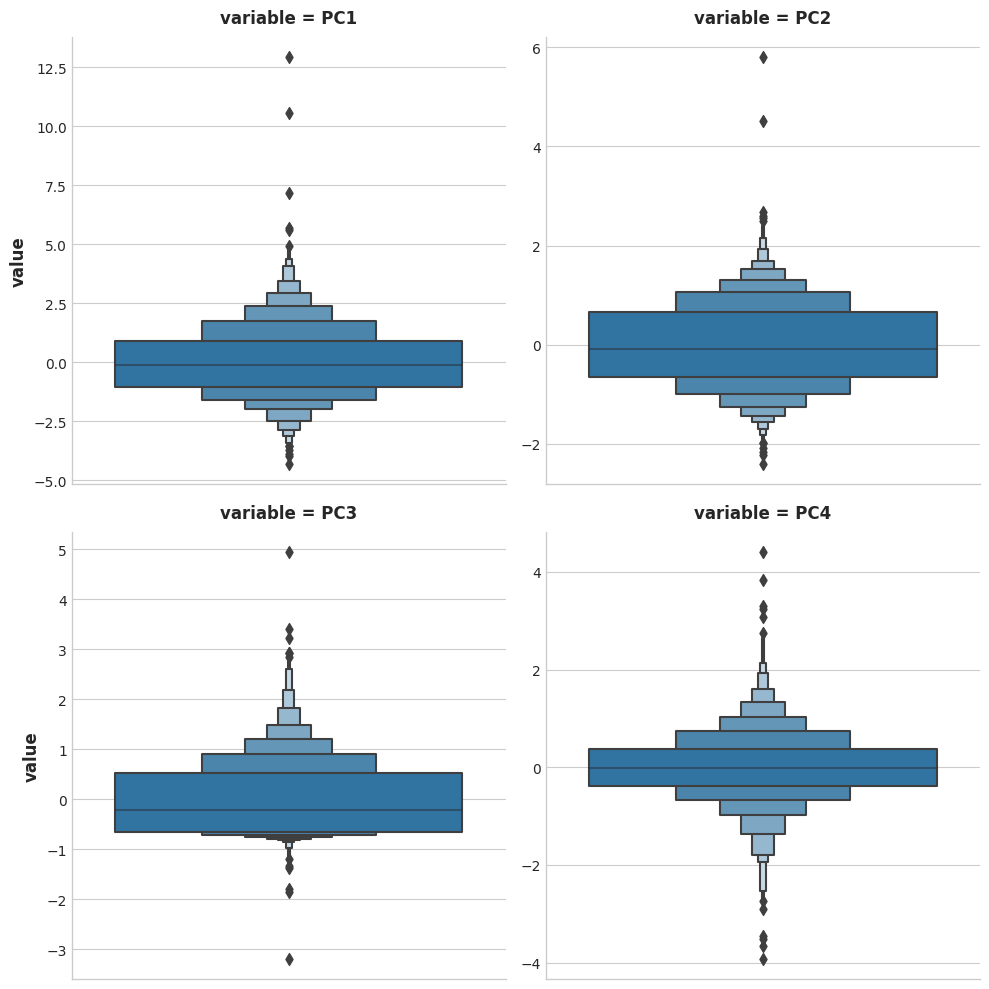

In [7]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

As you can see, in each of the components there are several points lying at the extreme ends of the distributions -- outliers, that is.

Now run the next cell to see those houses that sit at the extremes of a component:

In [8]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0


# 3) Outlier Detection

Do you notice any patterns in the extreme values? Does it seem like the outliers are coming from some special subset of the data?

After you've thought about your answer, run the next cell for the solution and some discussion.

In [9]:
# View the solution (Run this cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Notice that there are several dwellings listed as `Partial` sales in the `Edwards` neighborhood that stand out. A partial sale is what occurs when there are multiple owners of a property and one or more of them sell their "partial" ownership of the property.

These kinds of sales are often happen during the settlement of a family estate or the dissolution of a business and aren't advertised publicly. If you were trying to predict the value of a house on the open market, you would probably be justified in removing sales like these from your dataset -- they are truly outliers.


# Keep Going #

[**Apply target encoding**](https://www.kaggle.com/ryanholbrook/target-encoding) to give a boost to categorical features.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*